<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-this-notebook-does" data-toc-modified-id="What-this-notebook-does-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What this notebook does</a></span></li><li><span><a href="#Usual-Firedrake-and-Jupyter-preliminaries" data-toc-modified-id="Usual-Firedrake-and-Jupyter-preliminaries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Usual Firedrake and Jupyter preliminaries</a></span></li><li><span><a href="#A-test-problem,-and-a-spatial-mesh" data-toc-modified-id="A-test-problem,-and-a-spatial-mesh-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A test problem, and a spatial mesh</a></span></li><li><span><a href="#The-Explicit-(=Forward)-Euler-Method" data-toc-modified-id="The-Explicit-(=Forward)-Euler-Method-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Explicit (=Forward) Euler Method</a></span><ul class="toc-item"><li><span><a href="#Weak-form" data-toc-modified-id="Weak-form-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Weak form</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#Implicit(=Backward)-Euler-Method" data-toc-modified-id="Implicit(=Backward)-Euler-Method-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Implicit(=Backward) Euler Method</a></span></li><li><span><a href="#The-Crack-Nicolson-Method" data-toc-modified-id="The-Crack-Nicolson-Method-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>The Crack-Nicolson Method</a></span></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Exercises</a></span></li></ul></div>

# Example 5: Time dependent problems (Part 1)

[Niall Madden](https://www.niallmadden.ie/) _Dec 2024_

This notebook discusses how to solve a (parabolic) time-dependent PDE, in one dimension in space. We'll do this using the Explicit and Implicit Euler Methods. In Part 2, we'll use IRKSOME: https://www.firedrakeproject.org/Irksome/


## What this notebook does 
We'll consider methods for solving the Heat Equation: _find $u=u(t,x)$ such that_
$$u_t(t,x) + \mathcal{L}u(t,x)=0,
\qquad \text{ for } (t,x) \in (0,T) \times (x_0,x_1),$$
and subject to the initial condition $u(0,x)=g(x)$, and boundary conditions $u(t,x_0)=u(t,x_1)=0$. Here $\mathcal{L}$ is a spatial differential operator.

The specific example we'll study has $T=3$, $x_0=0$, $x_1=\pi$, and 
$$ u_t - u''(t,x)  = 0.$$

We'll impose the initial condition 
$u(0,x)=g(x)=\sin(x)$.

## Usual Firedrake and Jupyter preliminaries

In [1]:
import os
if "OMP_NUM_THREADS" not in os.environ:
    os.environ["OMP_NUM_THREADS"] = "1"  

In [2]:
from firedrake import *
import numpy as np
# %matplotlib notebook # use if you would like to zoom, etc.
import matplotlib.pyplot as plt

The next two cells are used to number equations, and to use $\LaTeX$ labelling and referencing.

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [4]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

## A test problem, and a spatial mesh

In [5]:
def g(x): return(sin(x))
x0,x1 = 0, np.pi
T = 3

N = 8   # number of mesh intervals in space
def u_e(t,x): return exp(-t)*sin(x) # exact solution

Define the mesh, and the space of piecewise linear functions on that space, and plot the true solution for $t=0, 1, 2, 3$. Note that this is the first time we have a mesh that is not on the interval $(0,1)$. So we using the `IntervalMesh` function, rather than `UnitIntervalMesh`. You can read more about it at https://www.firedrakeproject.org/_modules/firedrake/utility_meshes.html
(You are encouraged to get used to checking the API to see how functions work).

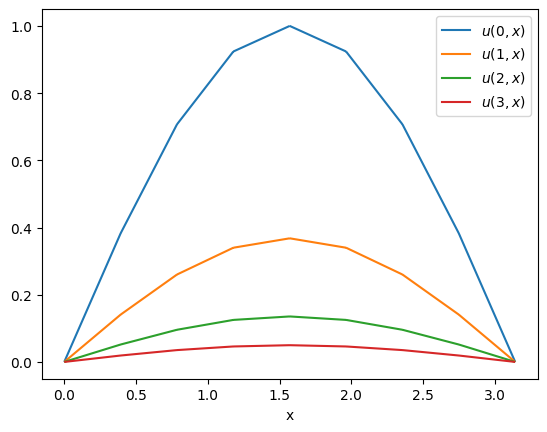

In [6]:
mesh1D = IntervalMesh(N, x0, right=x1)
Ue = FiniteElement("CG", mesh1D.ufl_cell(), 1)
V = FunctionSpace(mesh1D, Ue)
x = SpatialCoordinate(mesh1D)

u_e0 = Function(V).interpolate(u_e(0,x[0]))
u_e1 = Function(V).interpolate(u_e(1,x[0]))
u_e2 = Function(V).interpolate(u_e(2,x[0]))
u_e3 = Function(V).interpolate(u_e(3,x[0]))

fig, axes = plt.subplots()
plot(u_e0, axes=axes, label='$u(0,x)$') # numerical
plot(u_e1, axes=axes, label='$u(1,x)$') # numerical
plot(u_e2, axes=axes, label='$u(2,x)$') # numerical
plot(u_e3, axes=axes, label='$u(3,x)$') # numerical
plt.xlabel("x")
plt.legend()

##  The Explicit (=Forward) Euler Method

We wish to solve to problem on the time interval $[0,T]$. We'll use $M$ subintervals, so each is of length $\tau = T/M$. We'll denote the time points as $\{0=t_0, t_1, t_2, \dots, t_M=T\}$. So note that $t_k=k\tau$.

It is useful to write $u(t_k,x)$ as $u^{k}(x)$. With that notation, and using that 
$$\frac{\partial u(t_{k+1},x)}{\partial t} \approx \frac{u^{k+1}(x)-u^k(x)}{\tau}$$

With this discretization, we get a semi-discrete version of our original PDE:
$$\frac{u^{k+1}(x)-u^k(x)}{\tau} + \mathcal{L}u^{k}(t,x) = 0.$$
With a little rearranging, we get
$$u^{k+1}(x) = u^k(x) - \tau \mathcal{L}u^{k}(t,x).$$
For our specific example, this is
\begin{equation}
u^{k+1}(x) = u^k(x) + \tau u_{xx}^{k}(x),
\qquad \text{ for } k=0, 1, \dots, M-1.\label{eq:explicit euler}
\end{equation}


### Weak form
The weak form of the problem in $\eqref{eq:explicit euler}$ is: _find $u^{k+1} \in V$ such that_
$$
(u^{k+1}, v) = (u^k,v) + \tau (u_{xx}^{k},v). \qquad \text{ for } k=0, 1, \dots, M-1.
$$
After applying integration by parts on the last term, and assuming homogeneous boundary conditions, we get 
$$
(u^{k+1}, v) = (u^k,v) - \tau (u_{x}^{k},v_x). \qquad \text{ for } k=0, 1, \dots, M-1.
$$

### Implementation

N=8, M=128, ||u-uN||_0=3.08e-03


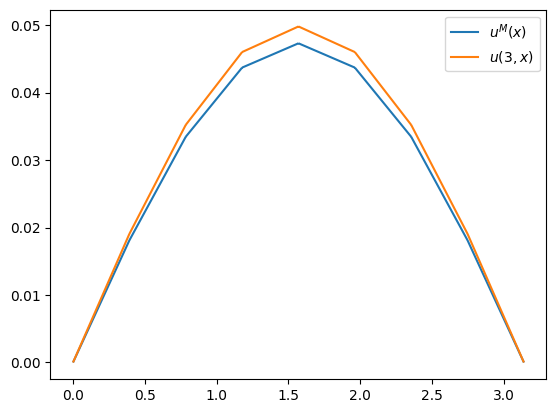

In [18]:
M = 128   # number of mesh intervals in time
tau = T/M
h = (x1-x0)/N
#print(f"N={N}, M={M}, h={h:.2e}, T*tau/h^2={T*tau/h**2}")

u_ = Function(V, name="step k").interpolate(u_e0) # initial value
uN = Function(V, name="step k+1") 

u = TrialFunction(V)
v = TestFunction(V)
a = u*v*dx 
L = u_*v*dx - tau*u_.dx(0)*v.dx(0)*dx
BC = DirichletBC(V, 0.0, "on_boundary")
  
for k in range(1,M):
    solve(a == L, uN, bcs=BC)
    u_.assign(uN)
    
    
Err_L2 = errornorm(u_e3, uN, norm_type='L2')
print(f"N={N}, M={M}, ||u-uN||_0={Err_L2:.2e}")

fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^M(x)$') 
plot(u_e3, axes=axes, label='$u(3,x)$') 
plt.legend()

The explicit Euler method is pretty easy, but it can be unstable unless $\tau/h^2$ is sufficiently small. So it can be expensive.

## Implicit(=Backward) Euler Method 

The Implicit Euler method can be written as 
$$\frac{u^{k+1}(x)-u^k(x)}{\tau} + \mathcal{L}u^{k+1}(t,x) = 0.$$
That is
$$u^{k+1}(x) - \tau \mathcal{L}u^{k+1}(t,x) = u^k(x).$$
For our specific example, the weak form of this is
$$
(u^{k+1}, v) +  \tau (u_{x}^{k+1},v_x) = (u^k,v) \qquad \text{ for } k=0, 1, \dots, M-1.
$$

Here is an implementation.

N=   8, M= 128, ||u-uN||_0=1.26e-03


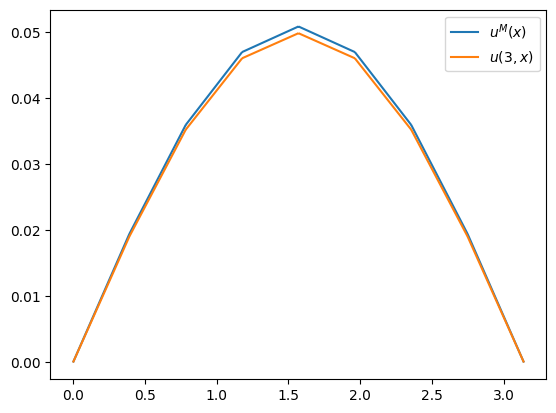

In [19]:
M = 128   # number of mesh intervals in time
tau = T/M
h = (x1-x0)/N

u_ = Function(V, name="step k").interpolate(u_e0) # initial value
uN = Function(V, name="step k+1") 

u = TrialFunction(V)
v = TestFunction(V)
a = u*v*dx + tau*u.dx(0)*v.dx(0)*dx
L = u_*v*dx 
BC = DirichletBC(V, 0.0, "on_boundary")
  
for k in range(1,M):
    solve(a == L, uN, bcs=BC)
    u_.assign(uN)
    
Err_L2 = errornorm(u_e3, uN, norm_type='L2')
print(f"N={N:4d}, M={M:4d}, ||u-uN||_0={Err_L2:.2e}")

fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^M(x)$') 
plot(u_e3, axes=axes, label='$u(3,x)$') 
plt.legend()

## The Crack-Nicolson Method

The semi-discrete version of this method can be written as 
$$\frac{u^{k+1}(x)-u^k(x)}{\tau} + 
\frac{1}{2}\bigg(\mathcal{L}u^{k+1}(t,x) + \mathcal{L}u^{k}(t,x) \bigg) = 0.$$

Here is an implementation.

N=8, M=128, ||u-uN||_0=9.26e-04


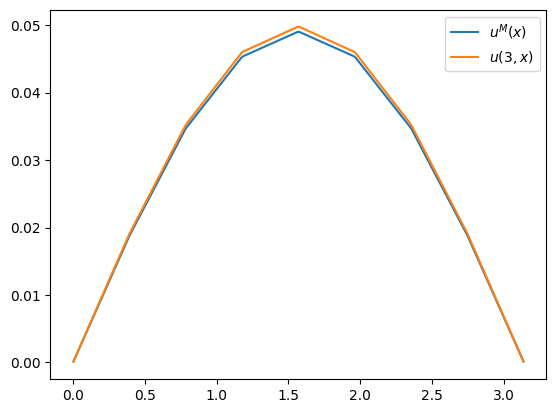

In [20]:
M = 128   # number of mesh intervals in time
tau = T/M
h = (x1-x0)/N

u_ = Function(V, name="step k").interpolate(u_e0) # initial value
uN = Function(V, name="step k+1") 

u = TrialFunction(V)
v = TestFunction(V)
a = u*v*dx + 0.5*tau*u.dx(0)*v.dx(0)*dx
L = u_*v*dx - 0.5*tau*u_.dx(0)*v.dx(0)*dx
BC = DirichletBC(V, 0.0, "on_boundary")
  
for k in range(1,M):
    solve(a == L, uN, bcs=BC)
    u_.assign(uN)
    
Err_L2 = errornorm(u_e3, uN, norm_type='L2')
print(f"N={N}, M={M}, ||u-uN||_0={Err_L2:.2e}")

fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^M(x)$') 
plot(u_e3, axes=axes, label='$u(3,x)$') 
plt.legend()

You should experiment with various values of $N$ and $M$ to demonstrate that this method is _unconditionally stable_. And, typically, more accurate that either of the Euler Methods, for given $N$ and $M$.

##  Exercises

1. Verify that the order of convergence of the Implicit Euler method, in time, is $\mathcal{O}{\tau}$. Since the actual error depends on both $N$ and $\tau$, you make have to choose $N$ large enough so that the temporal error dominates.
2. Verify that the order of convergence of the Crank-Nicolson method, in time, is $\mathcal{O}{\tau^2}$. Again, you may need a large value of $N$.
3. All three methods are examples of $\theta$-methods. Given an implementation of the general $\theta$-method.